In [1]:
# data source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

from heart_attack_prepreprocessing import get_heart_dataset

heart_dataset, data_headers = get_heart_dataset()


                   0      1      2      3      4
Age             40.0   49.0   37.0   48.0   54.0
RestingBP      140.0  160.0  130.0  138.0  150.0
Cholesterol    289.0  180.0  283.0  214.0  195.0
FastingBS        0.0    0.0    0.0    0.0    0.0
MaxHR          172.0  156.0   98.0  108.0  122.0
Oldpeak          0.0    1.0    0.0    1.5    0.0
sex_F            0.0    1.0    0.0    1.0    0.0
sex_M            1.0    0.0    1.0    0.0    1.0
pain_type_ASY    0.0    0.0    0.0    1.0    0.0
pain_type_ATA    1.0    0.0    1.0    0.0    0.0
pain_type_NAP    0.0    1.0    0.0    0.0    1.0
pain_type_TA     0.0    0.0    0.0    0.0    0.0
ecg_LVH          0.0    0.0    0.0    0.0    0.0
ecg_Normal       1.0    1.0    0.0    1.0    1.0
ecg_ST           0.0    0.0    1.0    0.0    0.0
angina_N         1.0    1.0    1.0    0.0    1.0
angina_Y         0.0    0.0    0.0    1.0    0.0
slope_Down       0.0    0.0    0.0    0.0    0.0
slope_Flat       0.0    1.0    0.0    1.0    0.0
slope_Up         1.0

In [123]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from run_dataset import run_dataset, preprocessing

index_table, base_fuzzy = preprocessing(heart_dataset)
y_actual, y_predicted = run_dataset(heart_dataset, index_table, base_fuzzy, points=1, close_threshold=0.5)

y_predicted = np.rint(np.array(y_predicted))  # convert to binary array to match targets type
accuracy = accuracy_score(y_actual, y_predicted)
f1 = f1_score(y_actual, y_predicted)

print(f"MaRz accuracy: {accuracy * 100:.2f}%\nMaRz F1 score: {f1:.4f}")
#```


data shape: (916, 21)
threshold for "close result": 0.5
739 close results of 916 lines, or 80.68%
points requested: 1
number with 1 points found: 810 or 88.43%
number with 2 points found: 43 or 4.69%
number with more points found: 63 or 6.88%
MaRz accuracy: 80.68%
MaRz F1 score: 0.8192


In [124]:
import numpy as np

# extract common test line
test_line_number = 100
test_input = heart_dataset[test_line_number]
heart_dataset = np.delete(heart_dataset, test_line_number, axis=0)

# Query MaRz with the test input and get a result

In [125]:
from dataset_preprocessing import generate_index_table, get_base_fuzzy
from get_alpha_sorted import get_alpha
from marz_get_output import get_output

index_table = generate_index_table(heart_dataset)
base_fuzzy = get_base_fuzzy(heart_dataset)

alpha, hyperbox = get_alpha(test_input[:-1], heart_dataset, index_table, base_fuzzy, 1)
output = get_output(test_input[:-1], heart_dataset, base_fuzzy * alpha, hyperbox)

print(f"The prediction that heart disease WILL {'' if output else 'NOT '}occur was derived from the following datum:")
for i in range(len(data_headers)):
    print(f"{data_headers[i]:15}: {heart_dataset[hyperbox[0]][i]}")

print(f"This prediction was {'' if test_input[-1] == output else 'not '}accurate.")


The prediction that heart disease WILL NOT occur was derived from the following datum:
Age            : 58.0
RestingBP      : 130.0
Cholesterol    : 197.0
FastingBS      : 0.0
MaxHR          : 131.0
Oldpeak        : 0.6
sex_F          : 1.0
sex_M          : 0.0
pain_type_ASY  : 1.0
pain_type_ATA  : 0.0
pain_type_NAP  : 0.0
pain_type_TA   : 0.0
ecg_LVH        : 0.0
ecg_Normal     : 1.0
ecg_ST         : 0.0
angina_N       : 1.0
angina_Y       : 0.0
slope_Down     : 0.0
slope_Flat     : 1.0
slope_Up       : 0.0
HeartDisease   : 0.0
This prediction was not accurate.


# Build tensorflow model

###  First, split the data for modeling

In [182]:
heart_df = get_heart_dataset(as_dataframe=True)
normalized_df = (heart_df - heart_df.min()) / (heart_df.max() - heart_df.min())

test_input = normalized_df.T.pop(test_line_number).T

# split 80/20 into training and testing sets
train_set = normalized_df.sample(frac=0.8, random_state=1)
test_set = normalized_df.drop(train_set.index)
valid_set = test_set.sample(frac=0.5, random_state=1)
test_set = test_set.drop(valid_set.index)

print(f"training set size: {train_set.size}\ntest set size: {test_set.size}\nvalidation set size: {valid_set.size}")
print(normalized_df[:5].T)


                   0      1      2      3      4
Age             40.0   49.0   37.0   48.0   54.0
RestingBP      140.0  160.0  130.0  138.0  150.0
Cholesterol    289.0  180.0  283.0  214.0  195.0
FastingBS        0.0    0.0    0.0    0.0    0.0
MaxHR          172.0  156.0   98.0  108.0  122.0
Oldpeak          0.0    1.0    0.0    1.5    0.0
sex_F            0.0    1.0    0.0    1.0    0.0
sex_M            1.0    0.0    1.0    0.0    1.0
pain_type_ASY    0.0    0.0    0.0    1.0    0.0
pain_type_ATA    1.0    0.0    1.0    0.0    0.0
pain_type_NAP    0.0    1.0    0.0    0.0    1.0
pain_type_TA     0.0    0.0    0.0    0.0    0.0
ecg_LVH          0.0    0.0    0.0    0.0    0.0
ecg_Normal       1.0    1.0    0.0    1.0    1.0
ecg_ST           0.0    0.0    1.0    0.0    0.0
angina_N         1.0    1.0    1.0    0.0    1.0
angina_Y         0.0    0.0    0.0    1.0    0.0
slope_Down       0.0    0.0    0.0    0.0    0.0
slope_Flat       0.0    1.0    0.0    1.0    0.0
slope_Up         1.0

### Plot the distribution of values to verify good split

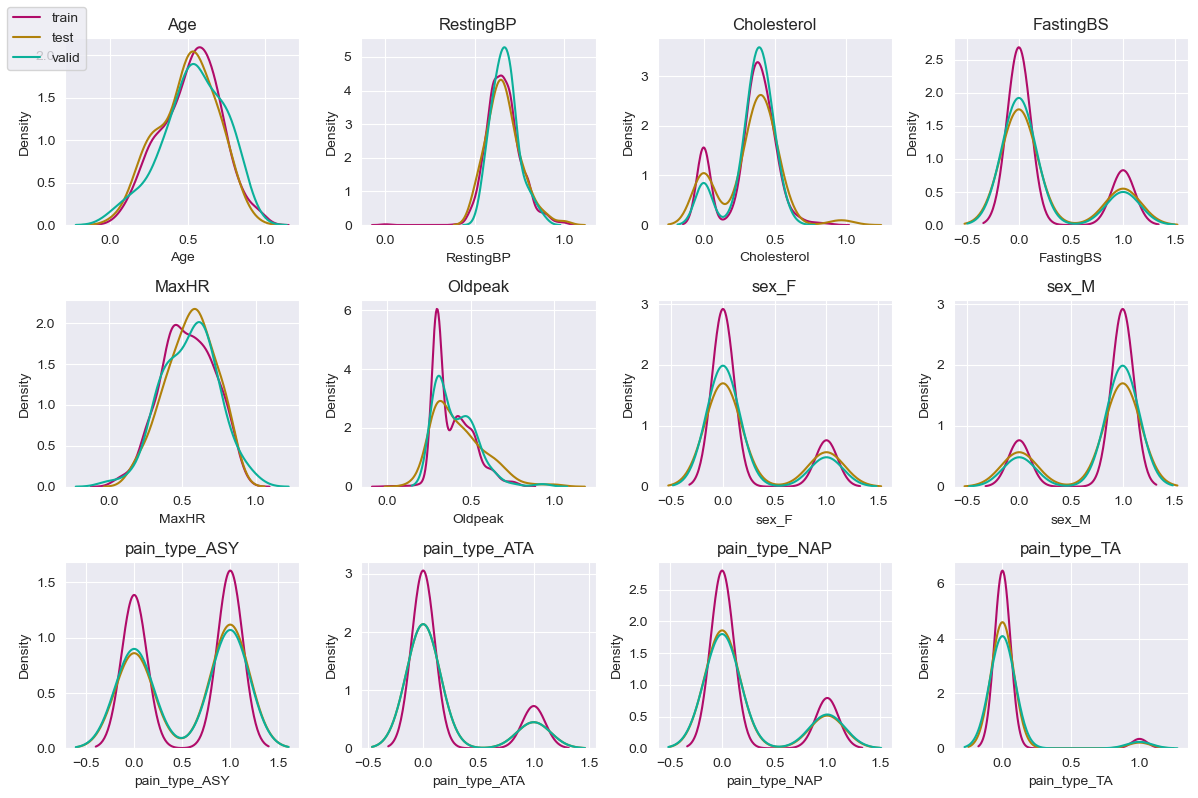

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot features per split
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for feature, ax in zip(list(normalized_df), axes.ravel()):
  sns.kdeplot(data=train_set, x=feature, ax=ax, color='#b00b69')
  sns.kdeplot(data=test_set, x=feature, ax=ax, color='#b0810b')
  sns.kdeplot(data=valid_set, x=feature, ax=ax, color='#0bb09a')
  ax.set_title(feature)
  #if feature == 'Snowfall':  # just put a legend on the last plot where there's room, since they're all the same
fig.legend(['train', 'test', 'valid'], loc='upper left')
fig.tight_layout()

### Split features from targets

In [184]:
x_train = train_set.copy()
x_test = test_set.copy()
x_valid = valid_set.copy()

y_train = x_train.pop('HeartDisease')
y_test = x_test.pop('HeartDisease')
y_valid = x_valid.pop('HeartDisease')

### Define plot_loss for graphing results

In [185]:
# this function from https://www.tensorflow.org/tutorials/keras/regression
def plot_loss(model_history):
    plt.plot(model_history.history['loss'], label='loss')
    plt.plot(model_history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [heart disease]')
    plt.legend()
    plt.grid(True)

### Model with tensorflow

In [186]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),  # input_shape=(20,), before activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### Compile the model

In [187]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    # loss='mean_absolute_error',
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

### Train the model

In [188]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=20,
    # verbose=0,
    validation_data=(x_valid, y_valid),
    # validation_split=0.1,  # hard code this
)

Epoch 1/100
37/37 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6063 - val_loss: 0.5897 - val_accuracy: 0.7065
Epoch 2/100
37/37 [==============================] - 0s 1ms/step - loss: 0.5478 - accuracy: 0.7629 - val_loss: 0.5082 - val_accuracy: 0.8261
Epoch 3/100
37/37 [==============================] - 0s 931us/step - loss: 0.4758 - accuracy: 0.8338 - val_loss: 0.4459 - val_accuracy: 0.8478
Epoch 4/100
37/37 [==============================] - 0s 907us/step - loss: 0.4209 - accuracy: 0.8665 - val_loss: 0.4029 - val_accuracy: 0.8370
Epoch 5/100
37/37 [==============================] - 0s 938us/step - loss: 0.3840 - accuracy: 0.8719 - val_loss: 0.3753 - val_accuracy: 0.8370
Epoch 6/100
37/37 [==============================] - 0s 863us/step - loss: 0.3596 - accuracy: 0.8706 - val_loss: 0.3552 - val_accuracy: 0.8370
Epoch 7/100
37/37 [==============================] - 0s 900us/step - loss: 0.3443 - accuracy: 0.8760 - val_loss: 0.3449 - val_accuracy: 0.8370
Epo

### Plot it

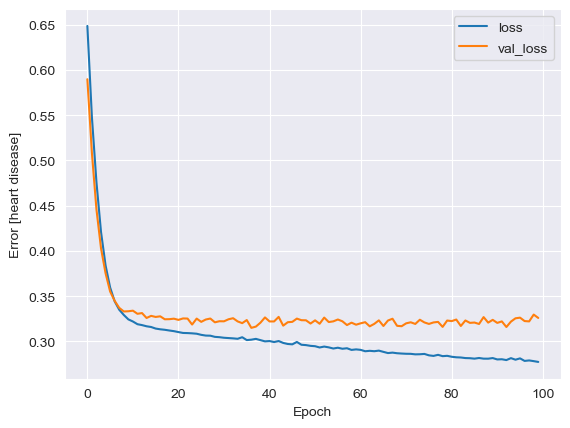

In [189]:
plot_loss(history)

### Predict with the same input as MaRz, using the tensorflow model

In [221]:
# match the input shape to the model input
test_input = np.array(test_input[:-1]).reshape((-1, 20))
print(test_input.shape)

(1, 20)


In [222]:
prediction = model.predict(test_input)
print(f"tensorflow prediction: {prediction}. test line actual: {test_input[-1]}")

1/1 [==============================] - 0s 10ms/step
tensorflow prediction: [[0.9500576]]. test line actual: 1.0
